In [6]:
%matplotlib inline
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil


test latex syntax $a = b^2$

In [7]:
# a useful function for interpolating model to new levels
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
    stop1 = timer()
    print  "reconstruct P time = ", stop1-start
    FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
    stop2 = timer()
    print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TP0 = T0.pressureRegrid(nlevs) # vertical regrid
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
    # vertical regridding seems to lose the mask so add one back in
    list = (TP0 > 0.9*TP0.missing_value) 
    TP0.mask = list # make sure the missing vales are masked
    TP0xav = cdutil.averager(TP0,axis="x")
    levsp0 = TP0xav.getAxis(0)
    lat0 = TP0xav.getAxis(1)

    TP1xav = getZAMP (g1, vname, levs)
    levsp1 = TP1xav.getAxis(0)
    lat1 = TP1xav.getAxis(1)

    TP2xav = getZAMP (g2, vname, levs)
    levsp2 = TP2xav.getAxis(0)
    lat2 = TP2xav.getAxis(1)

    DT2xav = TP2xav - TP0xav
    DT1xav = TP1xav - TP0xav

    return TP0xav, DT1xav, DT2xav;

def pltdat (TP0xav, DT1xav, DT2xav, dlevs=None):

    fig = plt.figure(figsize=(5., 10.), facecolor='white')
    axest = fig.add_subplot(311)
    axesm = fig.add_subplot(312)
    axesb = fig.add_subplot(313)
    if dlevs is None:
        dtrng = np.array([DT1.min(),DT2.min(),DT1.max(), DT2.max()])
        dlevs = pjr.findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
    print "diff contour levs", dlevs

    cmap = plt.cm.viridis_r
    pjr.plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP0xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
    cmap = pjr.diverge_map()
    pjr.plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
    pjr.plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
    plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

    # show plot
    #plt.show()
    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

            

levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]



 seas ANN
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980-2016_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_ANN_climo.nc
i Temperature
reconstruct P time =  0.512000799179
interp time 22.5403401852
reconstruct P time =  0.859115123749
interp time 51.2170209885
i.mname, dlevs T [-10.  -8.  -6.  -4.  -2.  -1.   1.   2.   4.   6.   8.  10.]
diff contour levs [-10.  -8.  -6.  -4.  -2.  -1.   1.   2.   4.   6.   8.

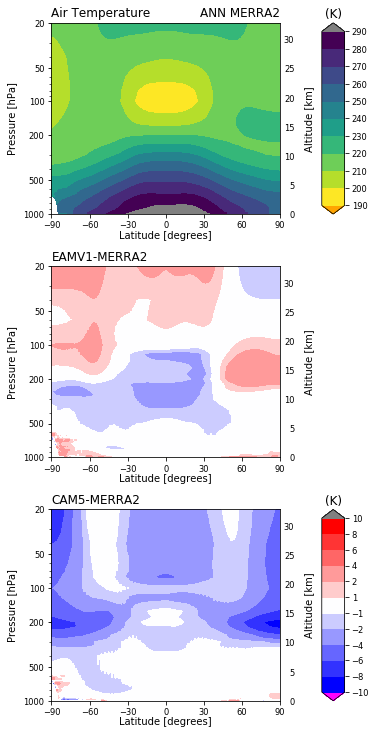

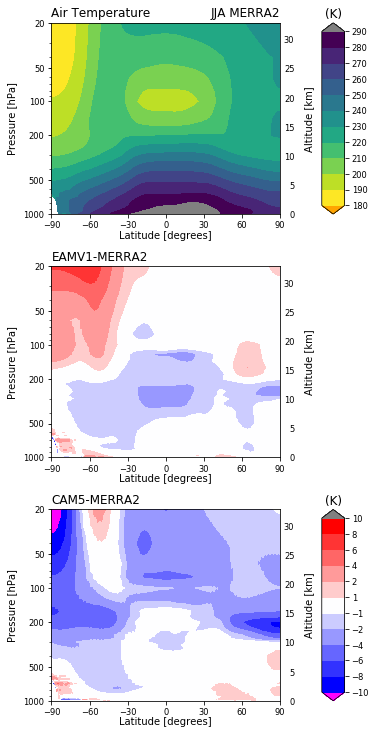

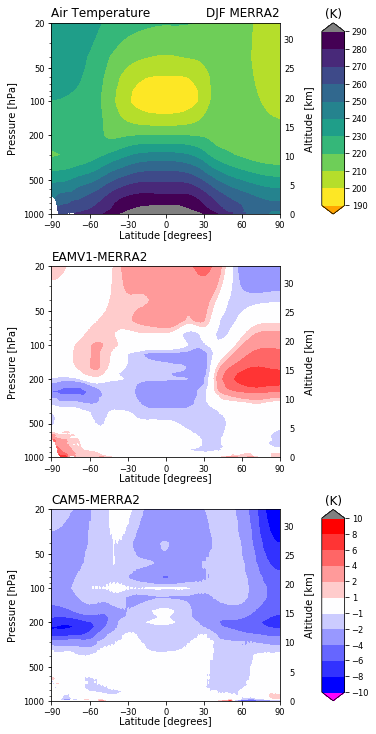

In [8]:
# identify the levels that we will interpolate to
levs = pjr.findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to

#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# the season to plot
seaslist = ["ANN","JJA","DJF"]

# observations
jdir = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/'

toadict = {'JJA':'MERRA2_JJA_1980-2016_climo.nc',
        'DJF':'MERRA2_DJF_1980-2016_climo.nc',
        'ANN':'MERRA2_ANN_1980-2016_climo.nc'}

# the dictionary of contour levels to use for particular field differences
dlevdict = {'RELHUM':np.array([-30.,-20.,-10.,-5.,5.,10.,20.,30.]),
            'T':np.array([-10.,-8.,-6.,-4.,-2.,-1.,1.,2.,4.,6.,8.,10.]),
            'U':np.array([-20.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,20.])}

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("LW_TOA", "FLUT","rlut"))
vlist.append(vsets("SW_TOA", "FSNT","rsut"))
#vlist.append(vsets("Surface Temperature", "T", "tsrf"))
#vlist.append(vsets("", "U", "ua"))


# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
#vlist.append(vsets("Relative Humidity", "RELHUM","hur"))
vlist.append(vsets("Temperature", "T", "ta"))
#vlist.append(vsets("Zonal Wind", "U", "ua"))

for seas in seaslist:
    print "\n\n\n seas", seas
    jname0 = jdir+toadict[seas]
    ltit0 = seas+" MERRA2"
    print "jname0", jname0

    # model1 dataset
    dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
    ltit1 = "CAM5-MERRA2"
    jname1 = dir1+f1
    print "jname1", jname1

    # model2 dataset
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    ltit2 = "EAMV1-MERRA2"
    jname2 = dir2+f2
    print "jname2", jname2  

    #------------------------------------------
    # open the files and make the plots

    g0 = cdms2.open(jname0);
    varlist = g0.listvariables();
    #print "varlist", varlist
    dims = g0.listdimension();
    g1 = cdms2.open(jname1);
    g2 = cdms2.open(jname2)

    for i in vlist:
        print "i", i.name
        pltname = "ZAVG_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
        TP0xav, DT1xav, DT2xav = getdat(g0, i.oname, g1, g2, i.mname)
        dlevs = dlevdict.get(i.mname,None)
        print "i.mname, dlevs", i.mname, dlevs
        pltdat(TP0xav, DT1xav, DT2xav, dlevs)
        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        print pltname+" complete"

In [ ]:
# a cell to explore alternate vertical interpolation
# but I havent actually done anything yet
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
    stop1 = timer()
    print  "reconstruct P time = ", stop1-start
    FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
    stop2 = timer()
    print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;

def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TP0 = T0.pressureRegrid(nlevs) # vertical regrid
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
    # vertical regridding seems to lose the mask so add one back in
    list = (TP0 > 0.9*TP0.missing_value) 
    TP0.mask = list # make sure the missing vales are masked
    TP0xav = cdutil.averager(TP0,axis="x")
    levsp0 = TP0xav.getAxis(0)
    lat0 = TP0xav.getAxis(1)

    TP1xav = getZAMP (g1, vname, levs)
    levsp1 = TP1xav.getAxis(0)
    lat1 = TP1xav.getAxis(1)

    TP2xav = getZAMP (g2, vname, levs)
    levsp2 = TP2xav.getAxis(0)
    lat2 = TP2xav.getAxis(1)

    DT2xav = TP2xav - TP0xav
    DT1xav = TP1xav - TP0xav

    return TP0xav, DT1xav, DT2xav;

 for i in vlist:
        print "i", i.name
        pltname = "ZAVG_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
        TP0xav, DT1xav, DT2xav = getdat(g0, i.oname, g1, g2, i.mname)

